In [1]:
# loading libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
# loading data
titanic_raw = pd.read_csv('titanic.csv')

In [3]:
#Processing data

titanic_processed = pd.DataFrame()

titanic_processed['Survived'] = titanic_raw['Survived']
titanic_processed['pclass'] = titanic_raw['Pclass']
titanic_processed['Sex'] = (titanic_raw['Sex'] == "male").astype(int)
titanic_processed['SibSp'] = titanic_raw['SibSp']
titanic_processed['Parch'] = titanic_raw['Parch']
titanic_processed['Age'] = titanic_raw['Age'].fillna(titanic_raw['Age'].mean())

titanic_processed

,Survived,pclass,Sex,SibSp,Parch,Age
0,0,3,1,1,0,22.000000
1,1,1,0,1,0,38.000000
2,1,3,0,0,0,26.000000
3,1,1,0,1,0,35.000000
4,0,3,1,0,0,35.000000
...,...,...,...,...,...,...
886,0,2,1,0,0,27.000000
887,1,1,0,0,0,19.000000
888,0,3,0,1,2,29.699118
889,1,1,1,0,0,26.000000


In [4]:
# randomizing the data and splitting it into training and testing

# torch.manual_seed(42)

rand_idx = torch.randperm(len(titanic_processed))

train_idx = rand_idx[:int(0.8*len(titanic_processed))]
val_idx = rand_idx[int(0.8*len(titanic_processed)):]

y_train = torch.from_numpy(titanic_processed.iloc[train_idx]['Survived'].values.astype(np.float32))
y_val = torch.from_numpy(titanic_processed.iloc[val_idx]['Survived'].values.astype(np.float32))

x_train = torch.from_numpy(titanic_processed.iloc[train_idx].drop('Survived', axis=1).values.astype(np.float32))
x_val = torch.from_numpy(titanic_processed.iloc[val_idx].drop('Survived', axis=1).values.astype(np.float32))

x_train

tensor([[ 2.,  0.,  0.,  0., 38.],
        [ 3.,  1.,  0.,  0., 16.],
        [ 3.,  1.,  0.,  0., 21.],
        ...,
        [ 3.,  1.,  0.,  0., 32.],
        [ 3.,  1.,  0.,  0., 33.],
        [ 3.,  0.,  0.,  0., 27.]])

In [5]:
# creating the model

class Layer(torch.nn.Module):
    """A simple feedforward layer with an activation function."""
    def __init__(self, n_feature, n_hidden, activation_function=None):
        super().__init__()

        self.linear = torch.nn.Linear(n_feature, n_hidden)

        if activation_function is None:
            self.activation_function = torch.nn.Sigmoid()
        else:
            self.activation_function = activation_function

    def forward(self, x):
        out = self.linear(x)
        out = self.activation_function(out)
        return out


class FeedForward(torch.nn.Module):
    """A simple feedforward neural network with two hidden layers."""
    def __init__(self, n_feature, n_hidden, n_output, activation_function, activation_function_last):
        super().__init__()

        self.layer0 = Layer(n_feature=n_feature, n_hidden=n_hidden, activation_function=activation_function)
        self.layer1 = Layer(n_feature=n_hidden, n_hidden=n_hidden, activation_function=activation_function)
        self.layer2 = Layer(n_feature=n_hidden, n_hidden=n_output, activation_function=activation_function_last)

    def forward(self, x):
        # (b, f) -> (b, h)
        out = self.layer0(x)
        # (b, h) -> (b, h)
        out = self.layer1(out)
        # (b, h) -> (b, o)
        out = self.layer2(out)
        return out

0
1
2
3
4
5
6
7
8
9
10
11
12


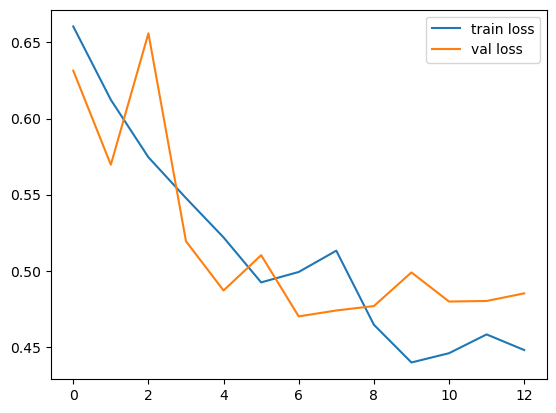

In [6]:
# Create a loss function
loss_fn = torch.nn.BCELoss()

# Create a feedforward neural network
feedforward = FeedForward(n_feature=5, n_hidden=64, n_output=1, activation_function=torch.nn.ReLU(), activation_function_last=torch.nn.Sigmoid()).cuda()

# Create an optimizer
optimizer = torch.optim.AdamW(feedforward.parameters(), lr=0.001, weight_decay=0.0)


batch_size = 8

train_losses = []
val_losses = []

best_loss = float('inf')
stopping_counter = 0
patience = 5
num_epochs = 1000

for epoch in range(num_epochs):
    print(epoch)
    random_index = torch.randperm(len(x_train))
    x_train = x_train[random_index]
    y_train = y_train[random_index]

    train_epoch_losses = []
    val_epoch_losses = []

    # Training loop.
    feedforward.train()  # Set the model to training mode.
    for start_index in range(0, len(x_train), batch_size):
        end_index = start_index + batch_size
        x_batch = x_train[start_index:end_index].cuda()
        y_batch = y_train[start_index:end_index].cuda()

        # Reset gradients.
        optimizer.zero_grad()

        # Forward pass.
        y_pred = feedforward(x_batch)

        # Compute loss.
        loss = loss_fn(y_pred.squeeze(), y_batch)

        # Backward pass.
        loss.backward()

        # Update weights.
        optimizer.step()

        train_epoch_losses.append(loss.item())

    # Validation loop.
    feedforward.eval()  # Set the model to evaluation mode.
    with torch.no_grad():
        for start_index in range(0, len(x_val), batch_size):
            end_index = start_index + batch_size
            x_batch = x_val[start_index:end_index].cuda()
            y_batch = y_val[start_index:end_index].cuda()
            y_val_pred = feedforward(x_batch)
            val_loss = loss_fn(y_val_pred.squeeze(), y_batch)

            val_epoch_losses.append(val_loss.item())

    train_losses.append(sum(train_epoch_losses) / len(train_epoch_losses))
    val_losses.append(sum(val_epoch_losses) / len(val_epoch_losses))

    if val_losses[-1] < best_loss:
        best_loss = val_losses[-1]
        torch.save(feedforward, './best_model.ckpt')
        stopping_counter = 0
    else:
        stopping_counter += 1

    if stopping_counter > patience:
        break

del x_batch, y_batch

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()

Text(0, 0.5, 'True values')

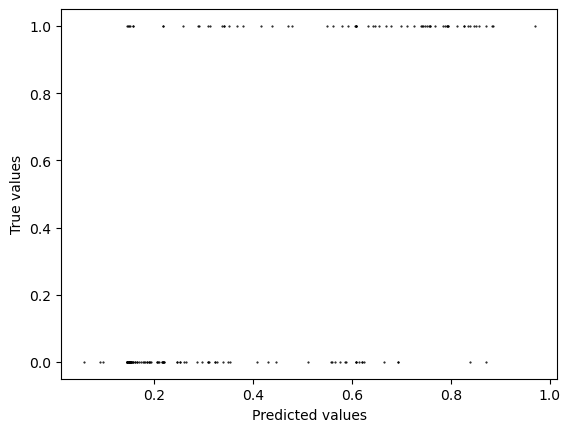

In [7]:
feedforward.load_state_dict(torch.load('./best_model.ckpt').state_dict())

feedforward.eval()  # Set the model to evaluation mode.

# Predict and detach the tensor from the computational graph and convert it to a NumPy array.
y_hat = feedforward(x_val.cuda()).cpu().detach().numpy()
y_hat_class = (y_hat > 0.5).astype(int).squeeze()
y_val_class = y_val.numpy().astype(int)

plt.plot(y_hat, y_val, 'o', markersize=0.5, color='black')
plt.xlabel('Predicted values')
plt.ylabel('True values')

In [8]:
# true negative | false positive
# false negative | true positive
confusion_matrix(y_val_class, y_hat_class, normalize='true')

array([[0.82882883, 0.17117117],
       [0.33823529, 0.66176471]])